## Импорты и установка модулей и библиотек

In [20]:
import pandas as pd
import numpy as np
from datetime import timedelta
from calendar import day_name

from statsmodels.tsa.seasonal import seasonal_decompose

#для визуализации
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(rc={'figure.figsize':(15,7)},style="whitegrid")
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

## Считывание и предобработка данных

In [2]:
df = pd.read_csv("/content/HistoricalData_1742404356306.csv", parse_dates=['Date'])

In [3]:
df.head()

,Date,Close/Last,Volume,Open,High,Low
0,2025-03-18,$192.82,40414870,$192.52,$194.00,$189.38
1,2025-03-17,$195.74,47341750,$198.77,$199.00,$194.3247
2,2025-03-14,$197.95,38096660,$197.41,$198.65,$195.32
3,2025-03-13,$193.89,41270760,$198.165,$198.8799,$191.82
4,2025-03-12,$198.89,43679280,$200.72,$201.52,$195.29


In [4]:
df.dtypes

,0
Date,datetime64[ns]
Close/Last,object
Volume,int64
Open,object
High,object
Low,object


In [5]:
df['Open']=df['Open'].str.replace('$','')
df['Close/Last']=df['Close/Last'].str.replace('$','')
df['High']=df['High'].str.replace('$','')
df['Low']=df['Low'].str.replace('$','')

In [6]:
df['Open']=df['Open'].astype(float)
df['Close/Last']=df['Close/Last'].astype(float)
df['High']=df['High'].astype(float)
df['Low']=df['Low'].astype(float)

In [7]:
df.isna().sum()

,0
Date,0
Close/Last,0
Volume,0
Open,0
High,0
Low,0


На первый взгляд кажется, что пропусков нет, но они есть, например, в праздничные дни, когда биржа не работала, их нужно заполнить для корректной работы моделей

In [9]:
df_copy = df.set_index('Date').asfreq('B')
df_copy['Close/Last'] = df_copy['Close/Last'].interpolate(method='time')
df_copy['Volume'] = df_copy['Volume'].interpolate(method='time')
df_copy['Open'] = df_copy['Open'].interpolate(method='time')
df_copy['High'] = df_copy['High'].interpolate(method='time')
df_copy['Low'] = df_copy['Low'].interpolate(method='time')

In [10]:
df_copy.isna().sum()

,0
Close/Last,0
Volume,0
Open,0
High,0
Low,0


## Корреляция между признаками

In [12]:
corr_matrix = df.corr()

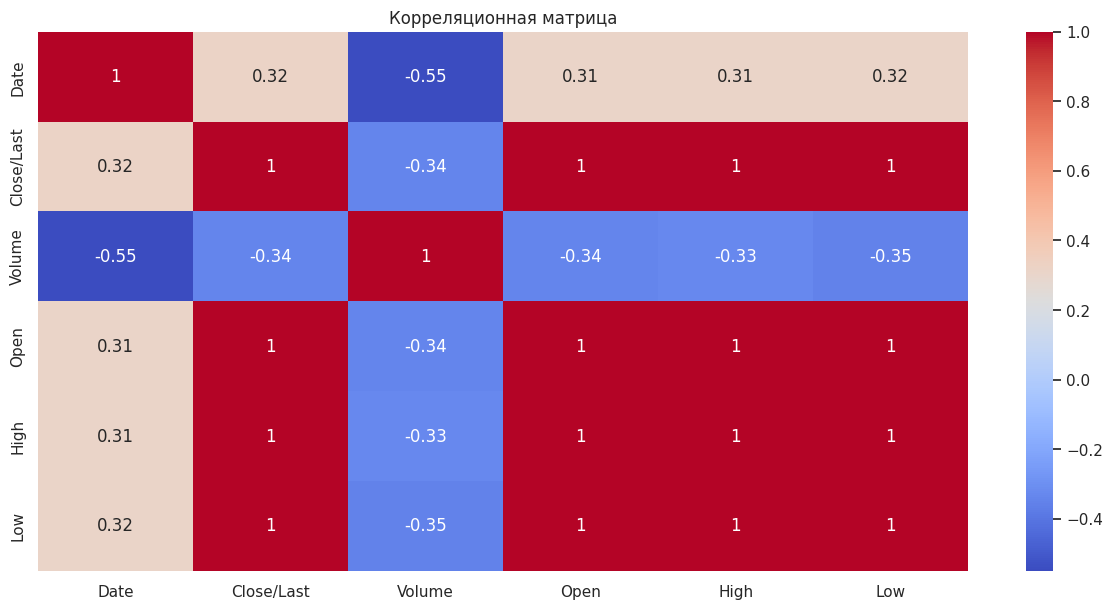

In [13]:
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()

In [15]:
df_copy = df_copy.reset_index()

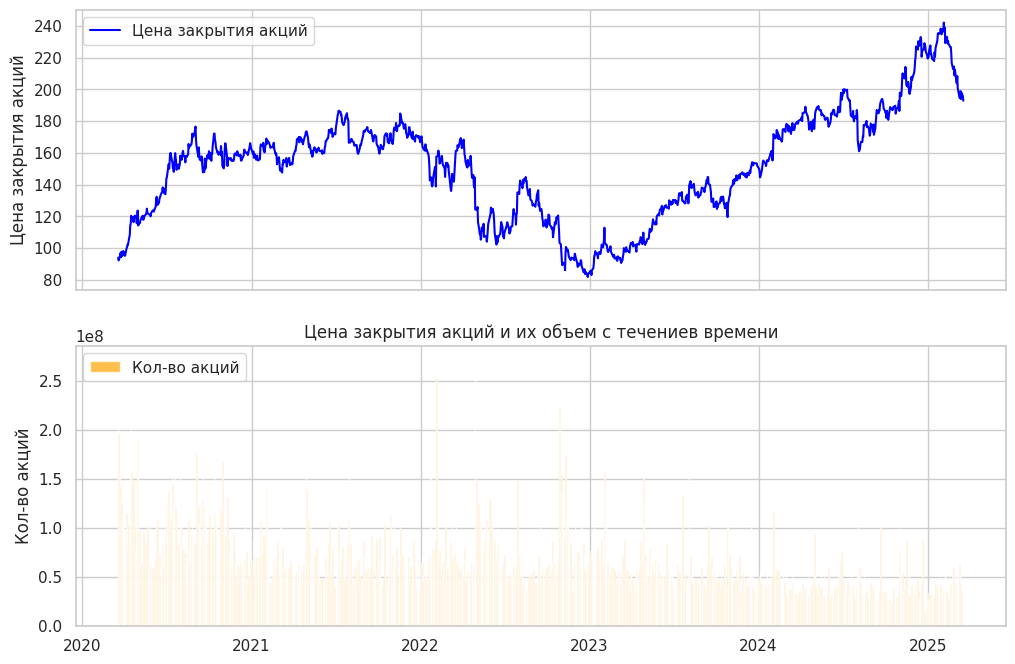

In [17]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# График цены закрытия
ax1.plot(df_copy['Date'], df_copy['Close/Last'], color='blue', label='Цена закрытия акций')
ax1.set_ylabel('Цена закрытия акций')
ax1.legend(loc='upper left')
ax1.grid(True)

# График объема
ax2.bar(df_copy['Date'], df_copy['Volume'], color='orange', alpha=0.7, label='Кол-во акций')
ax2.set_ylabel('Кол-во акций')
ax2.legend(loc='upper left')
ax2.grid(True)

plt.title('Цена закрытия акций и их объем с течениев времени')
plt.show()

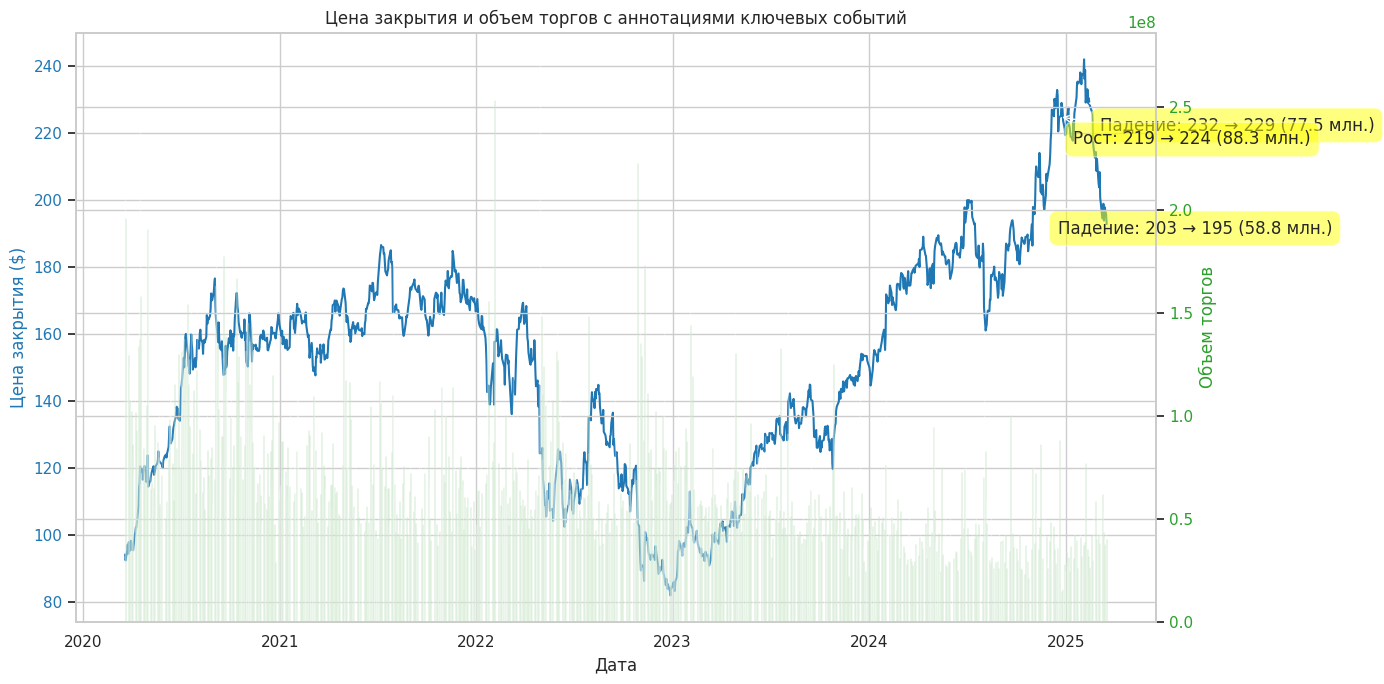

In [18]:
fig, ax1 = plt.subplots(figsize=(14, 7))

# График цены
color = 'tab:blue'
ax1.set_xlabel('Дата')
ax1.set_ylabel('Цена закрытия ($)', color=color)
ax1.plot(df_copy['Date'], df_copy['Close/Last'], color=color, label='Цена закрытия')
ax1.tick_params(axis='y', labelcolor=color)

# График объема (вторичная ось)
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Объем торгов', color=color)
ax2.bar(df_copy['Date'], df_copy['Volume'], color=color, alpha=0.3, label='Объем торгов')
ax2.tick_params(axis='y', labelcolor=color)

# Аннотации ключевых событий
events = {
    '2025-02-07': 'Падение: 232 → 229 (77.5 млн.)',
    '2024-12-20': 'Рост: 219 → 224 (88.3 млн.)',
    '2024-11-21': 'Падение: 203 → 195 (58.8 млн.)'
}

for date_str, desc in events.items():
    date = pd.to_datetime(date_str)
    idx = df_copy[df_copy['Date'] == date].index[0]
    ax1.annotate(desc, xy=(date, df_copy['Close/Last'].iloc[idx]),
                 xytext=(10, -20), textcoords='offset points',
                 arrowprops=dict(arrowstyle='->'), bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))

plt.title('Цена закрытия и объем торгов с аннотациями ключевых событий')
fig.tight_layout()
plt.show()

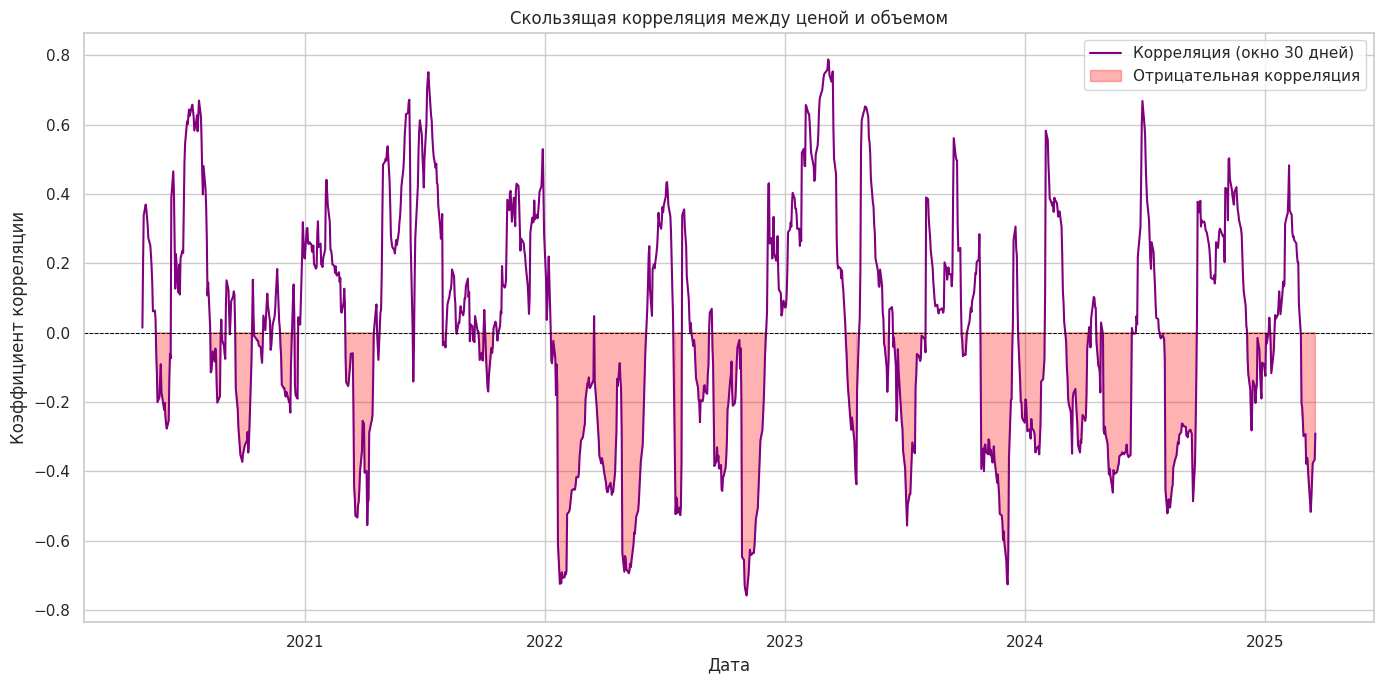

In [19]:
# Расчет скользящей корреляции (30 дней)
window = 30
rolling_corr = df_copy['Close/Last'].rolling(window=window).corr(df_copy['Volume'])

# Создание графика
plt.figure(figsize=(14, 7))
plt.plot(df_copy['Date'], rolling_corr, label=f'Корреляция (окно {window} дней)', color='purple')

# Выделение отрицательных значений
plt.fill_between(df_copy['Date'], rolling_corr, where=(rolling_corr < 0), color='red', alpha=0.3, label='Отрицательная корреляция')

# Горизонтальная линия для нуля
plt.axhline(0, color='black', linestyle='--', linewidth=0.7)

plt.title('Скользящая корреляция между ценой и объемом')
plt.xlabel('Дата')
plt.ylabel('Коэффициент корреляции')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Декомпозиция исходного временного ряда

In [21]:
df_ = df_copy.set_index('Date').asfreq('B')
series = df_['Close/Last']

### мультипликативная декомпозиция

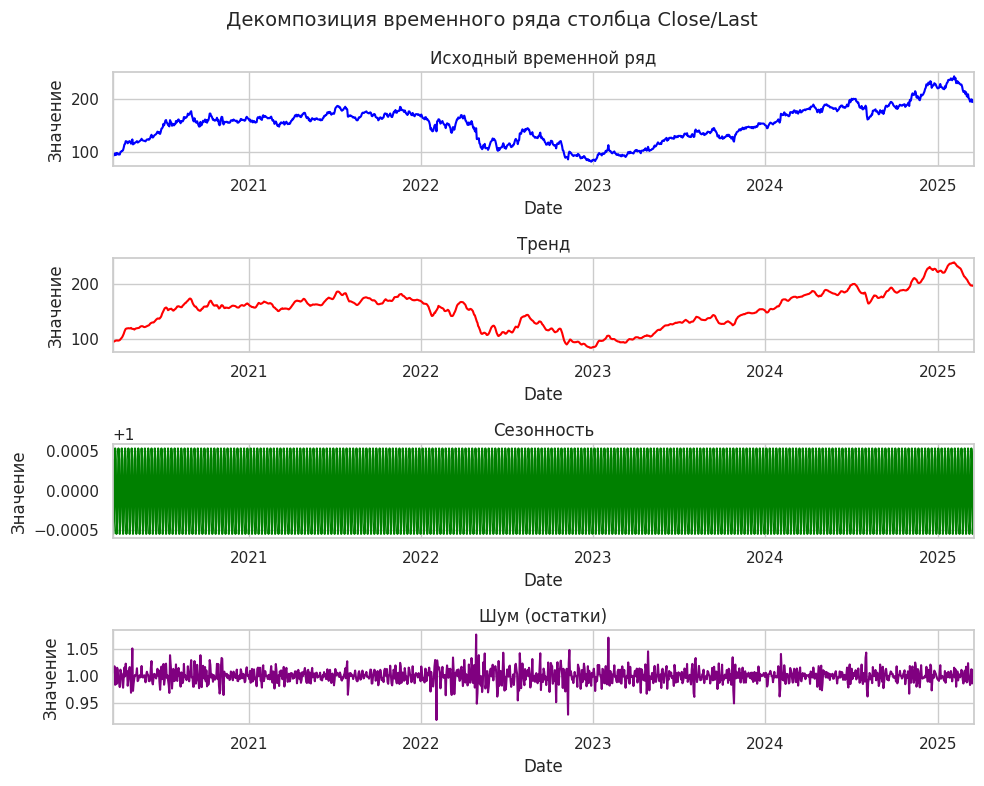

In [22]:
result = seasonal_decompose(series, model='multiplicative')
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))
fig.suptitle('Декомпозиция временного ряда столбца Close/Last', fontsize=14)

# Исходный ряд
result.observed.plot(ax=ax1, color='blue', title='Исходный временной ряд', legend=False)
ax1.set_ylabel('Значение')

# Тренд
result.trend.plot(ax=ax2, color='red', title='Тренд', legend=False)
ax2.set_ylabel('Значение')

# Сезонность
result.seasonal.plot(ax=ax3, color='green', title='Сезонность', legend=False)
ax3.set_ylabel('Значение')

# Шум (остатки)
result.resid.plot(ax=ax4, color='purple', title='Шум (остатки)', legend=False)
ax4.set_ylabel('Значение')

plt.tight_layout()
plt.show()

## аддитивная декомпозиция

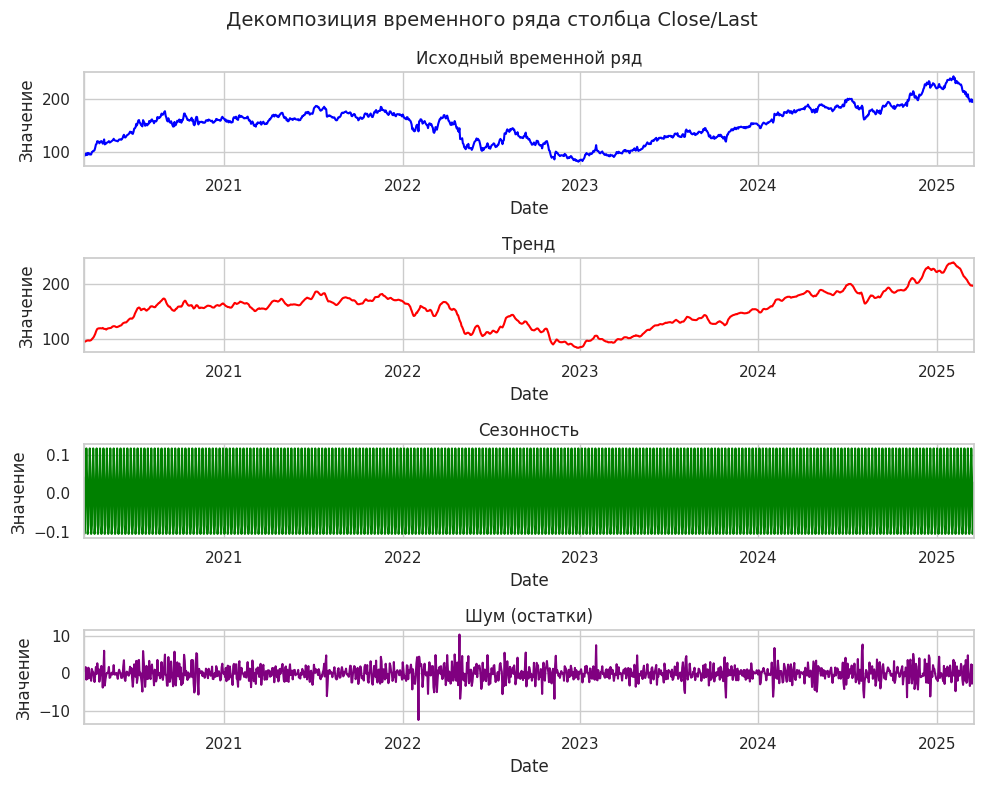

In [23]:
result = seasonal_decompose(series, model='additive')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))
fig.suptitle('Декомпозиция временного ряда столбца Close/Last', fontsize=14)

# Исходный ряд
result.observed.plot(ax=ax1, color='blue', title='Исходный временной ряд', legend=False)
ax1.set_ylabel('Значение')

# Тренд
result.trend.plot(ax=ax2, color='red', title='Тренд', legend=False)
ax2.set_ylabel('Значение')

# Сезонность
result.seasonal.plot(ax=ax3, color='green', title='Сезонность', legend=False)
ax3.set_ylabel('Значение')

# Шум (остатки)
result.resid.plot(ax=ax4, color='purple', title='Шум (остатки)', legend=False)
ax4.set_ylabel('Значение')

plt.tight_layout()
plt.show()